In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

In [2]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [3]:
def compute_inverse_symmetric_matrix(X):
    L, lower = jax.scipy.linalg.cho_factor(X, lower=True)
    u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
    L_t, lower = jax.scipy.linalg.cho_factor(X, lower=False)
    H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
    return H_inv

In [4]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.17 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.8299, 50 iterations in 0.8759 sec
Iteration  100, KL divergence 0.9224, 50 iterations in 0.7417 sec
Iteration  150, KL divergence 0.9572, 50 iterations in 0.5398 sec
Iteration  200, KL divergence 0.9972, 50 iterations in 0.5409 sec
Iteration  250, KL divergence 0.9107, 50 iterations in 0.5397 sec
   --> Time elapsed: 3.24 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.2017, 50 iterations in 0.5405 sec
Iteration  100, KL divergence 0.1973, 50 iterations in 0.5402 sec
Iteration  150, KL divergence 0.1972, 50 iterations in 0.5406 sec
Iteration  200, KL divergence 0.1972, 50 iterations in 0.5379 sec
Iteration 

In [5]:
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

In [6]:
dy1, H1, J1 = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [7]:
v, w = np.linalg.eigh(H1)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

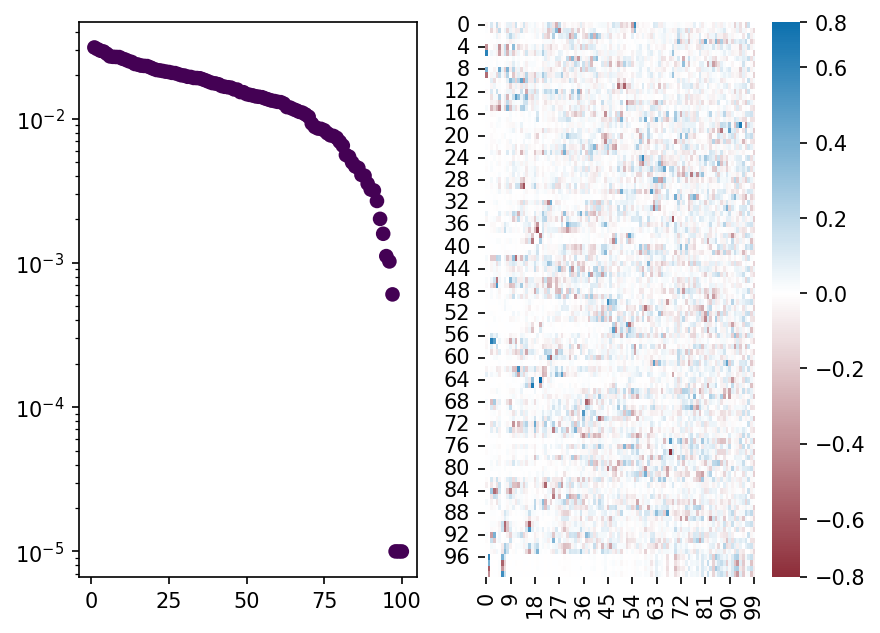

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
ax1.set_yscale('log')

<AxesSubplot: >

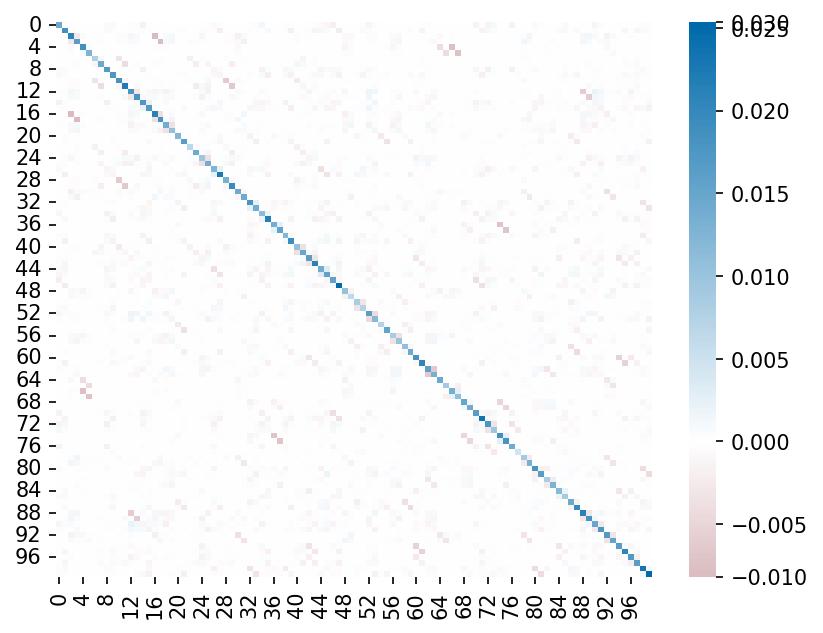

In [55]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H1, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H1), vmax=np.max(H1))), ax=ax1)

In [12]:
f = lambda y: KL_divergence(X_flat, y, X_unflattener, Y_unflattener)

In [13]:
df = lambda y: jax.grad(f)(y)

In [14]:
df2 = lambda y: jax.jacrev(f)(y)

In [15]:
ddf = lambda y: jacfwd(df)(y)

In [16]:
ddf(Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([[ 1.1966176e-02,  1.0860544e-03, -1.7953763e-04, ...,
        -1.5388685e-04, -5.3074014e-05,  4.5668727e-05],
       [ 1.0860544e-03,  9.6849510e-03,  2.8440183e-05, ...,
         6.6039589e-05,  1.8544105e-04, -8.3014951e-05],
       [-1.7953763e-04,  2.8440176e-05,  1.6229780e-02, ...,
         3.6712704e-04, -1.3232676e-04, -5.3030311e-04],
       ...,
       [-1.5388690e-04,  6.6039574e-05,  3.6712716e-04, ...,
         1.3333470e-02,  1.3563759e-04, -4.2441476e-04],
       [-5.3074011e-05,  1.8544099e-04, -1.3232666e-04, ...,
         1.3563762e-04,  1.9149888e-02,  2.9684987e-03],
       [ 4.5668712e-05, -8.3014951e-05, -5.3030311e-04, ...,
        -4.2441476e-04,  2.9684985e-03,  1.7212586e-02]], dtype=float32)

In [4]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [13]:
f2 = lambda y: KL_divergence_dy(X_flat, y, X_unflattener, Y_unflattener)
df_2 = lambda y: jax.jacrev(f2)(y)

In [19]:
print(df_2(Y_flat))

Computing pairwise distances...
Starting binary search
Entered binary search function
[[ 1.1966180e-02  1.0860544e-03 -1.7953763e-04 ... -1.5388695e-04
  -5.3074044e-05  4.5668741e-05]
 [ 1.0860553e-03  9.6849529e-03  2.8440190e-05 ...  6.6039589e-05
   1.8544105e-04 -8.3014995e-05]
 [-1.7953763e-04  2.8440165e-05  1.6229780e-02 ...  3.6712724e-04
  -1.3232676e-04 -5.3030311e-04]
 ...
 [-1.5388697e-04  6.6039589e-05  3.6712727e-04 ...  1.3333475e-02
   1.3563770e-04 -4.2441479e-04]
 [-5.3074058e-05  1.8544112e-04 -1.3232675e-04 ...  1.3563772e-04
   1.9149888e-02  2.9684997e-03]
 [ 4.5668698e-05 -8.3014980e-05 -5.3030316e-04 ... -4.2441487e-04
   2.9684994e-03  1.7212590e-02]]


In [60]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [61]:
v, w = np.linalg.eigh(H1)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

In [62]:
u = lambda y: (y - Y_flat) @ w_sorted

In [63]:
def g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R^nx2
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, num = y2q(Y)
    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    return np.ravel(4 * np.sum((PQ_exp * Y_diffs_wt), axis=1))[:97] # Nx2

In [64]:
w_sorted_sub = w_sorted[:, :97]
#w_sorted_sub = w_sorted
g_fun2 = lambda u: g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [65]:
w_sorted_sub.shape

(100, 97)

In [66]:
dg = jax.jacrev(g_fun2)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


In [67]:
dg.shape

(97, 97)

<AxesSubplot: >

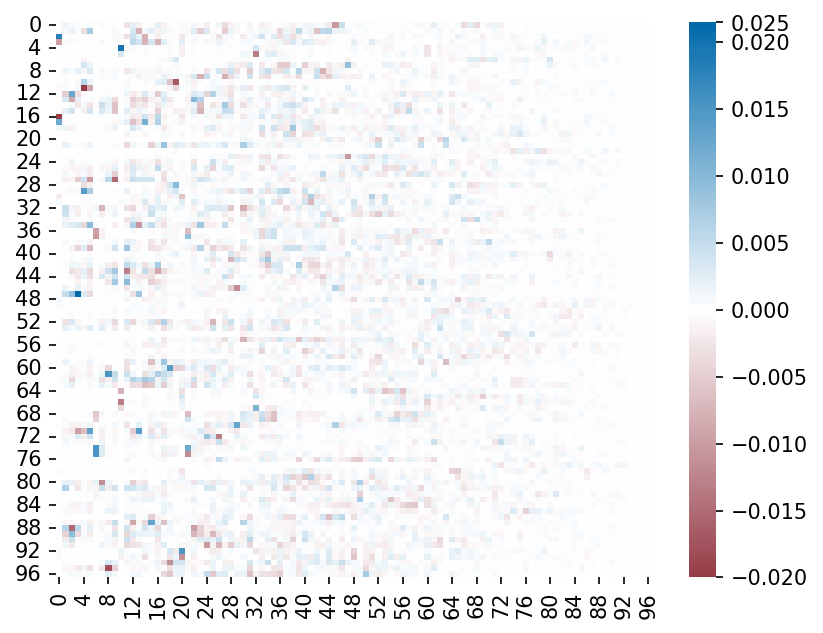

In [68]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg), vmax=np.max(dg))), ax=ax1)

In [69]:
a, s, b = np.linalg.svd(dg)

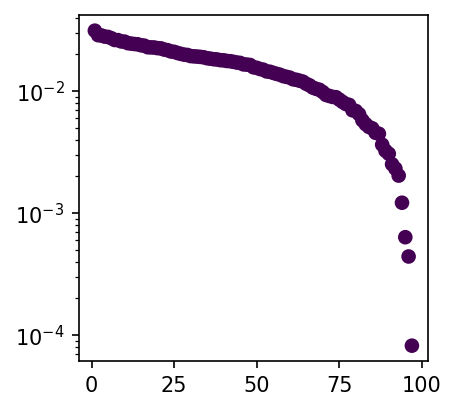

In [70]:
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

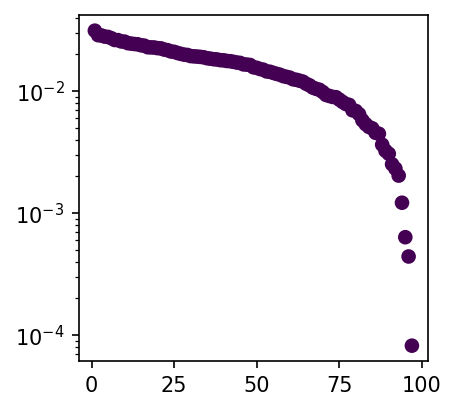

In [71]:
a, s, b = np.linalg.svd(dg[:97, :97])
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

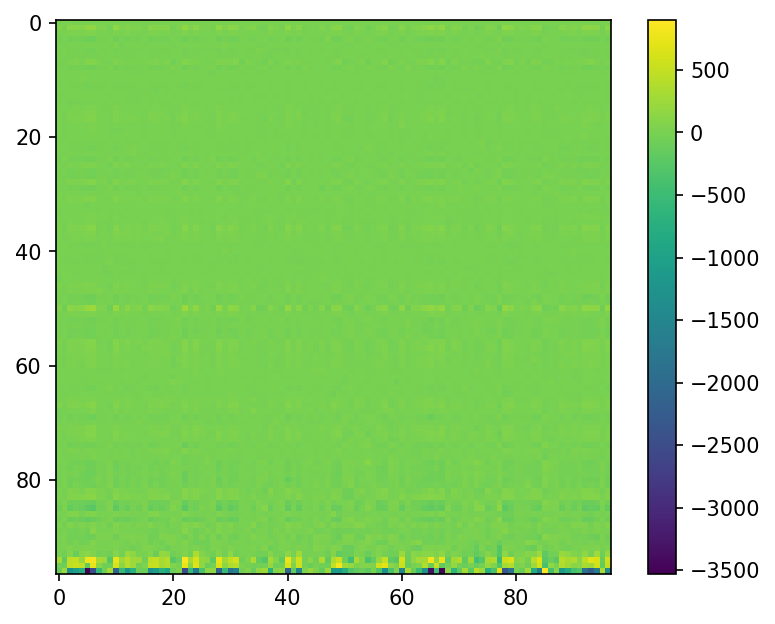

In [72]:
plt.imshow(np.linalg.inv(dg))
plt.colorbar()

In [73]:
g_fun_x = lambda x: g2(x, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)
dg_x = jax.jacrev(g_fun_x)(X_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [74]:
dg_x[:, 0]

Array([-3.56528070e-03, -2.48927710e-04,  5.76550883e-05,  1.94237691e-06,
       -9.43282794e-06, -4.22058201e-06,  1.93900778e-05,  2.24928499e-05,
        1.55565038e-04, -4.85389937e-05,  3.10040559e-05,  1.80427851e-05,
        1.50256717e-04, -2.63363236e-05,  2.61601905e-04,  2.85989790e-05,
        5.30891193e-05,  1.36475810e-05,  1.03052742e-04, -7.62215204e-05,
        1.66088976e-05, -1.15180137e-05,  2.03389045e-05,  2.71460813e-05,
        5.10495229e-05, -2.32961393e-05,  1.27641993e-04,  4.19532334e-05,
        2.81317734e-05,  3.72903196e-06, -2.36903361e-07,  5.10570680e-05,
        3.96955766e-05, -7.21646393e-06,  9.73268034e-05,  5.61637644e-05,
        3.00739066e-06, -2.61869791e-05,  1.58972456e-04,  1.11137808e-04,
        7.70043771e-05, -1.63200457e-06,  7.63391654e-05, -7.63516800e-06,
        1.19675839e-04,  2.51080164e-05,  1.07892069e-04,  1.28172367e-04,
        1.44437317e-05, -5.47893360e-05,  4.75507295e-05,  3.86772117e-05,
        3.23322776e-04, -

In [75]:
J1[:, 0]

Array([-3.56527930e-03, -2.48927943e-04,  5.76550447e-05,  1.94237964e-06,
       -9.43286614e-06, -4.22057747e-06,  1.93900632e-05,  2.24928663e-05,
        1.55565111e-04, -4.85390410e-05,  3.10040450e-05,  1.80427814e-05,
        1.50256732e-04, -2.63363909e-05,  2.61601788e-04,  2.85989499e-05,
        5.30891048e-05,  1.36475664e-05,  1.03052735e-04, -7.62215350e-05,
        1.66088794e-05, -1.15179973e-05,  2.03389027e-05,  2.71460922e-05,
        5.10494974e-05, -2.32961465e-05,  1.27641964e-04,  4.19532553e-05,
        2.81317461e-05,  3.72904105e-06, -2.36927917e-07,  5.10570608e-05,
        3.96955438e-05, -7.21643300e-06,  9.73267524e-05,  5.61637535e-05,
        3.00739521e-06, -2.61869554e-05,  1.58972442e-04,  1.11137873e-04,
        7.70043625e-05, -1.63202822e-06,  7.63391363e-05, -7.63517710e-06,
        1.19675817e-04,  2.51080401e-05,  1.07892032e-04,  1.28172367e-04,
        1.44437017e-05, -5.47892960e-05,  4.75506931e-05,  3.86772372e-05,
        3.23322514e-04, -

In [76]:
du_dx = - np.linalg.inv(dg) @ dg_x

In [77]:
dy_dx = w_sorted_sub @ du_dx

In [101]:
dy_dx.shape

(100, 2500)

<AxesSubplot: >

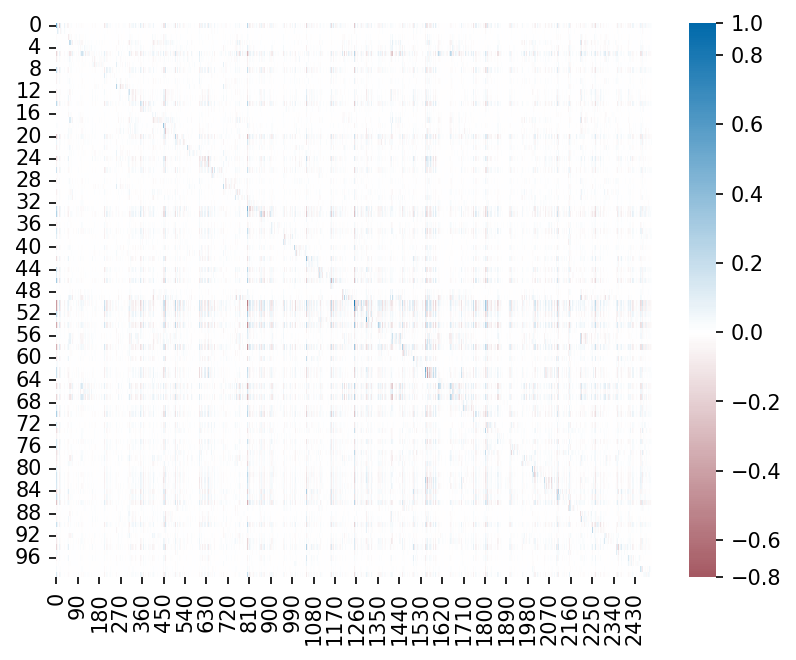

In [79]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_dx), vmax=np.max(dy_dx))), ax=ax1)

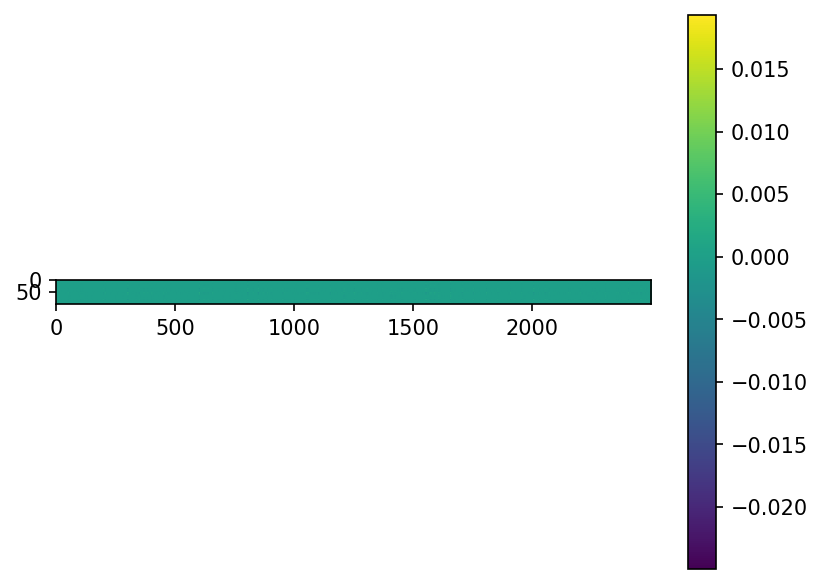

In [84]:
plt.imshow(dy_dx-dy)
plt.colorbar()

In [80]:
dy, H, J = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

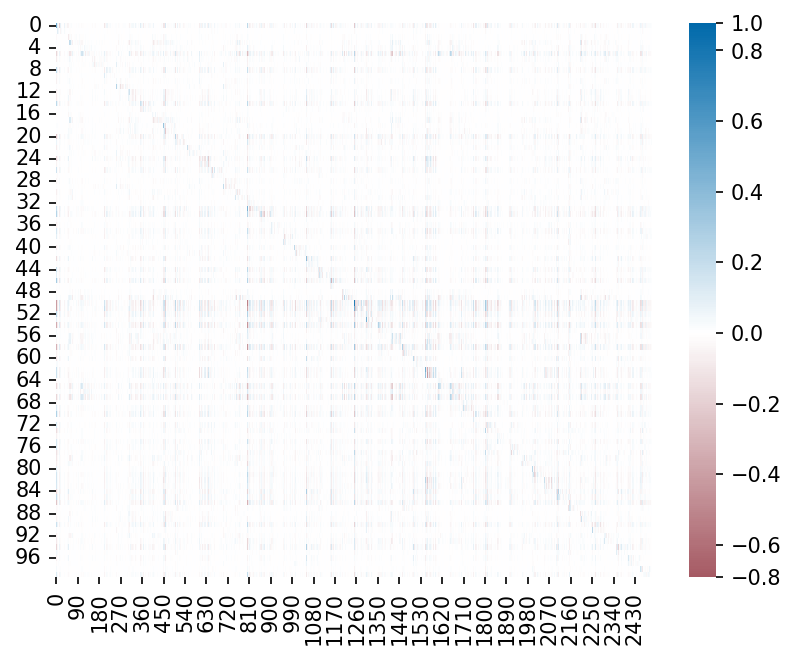

In [81]:
f = plt.figure()
sns.heatmap(dy, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy), vmax=np.max(dy))))

<AxesSubplot: >

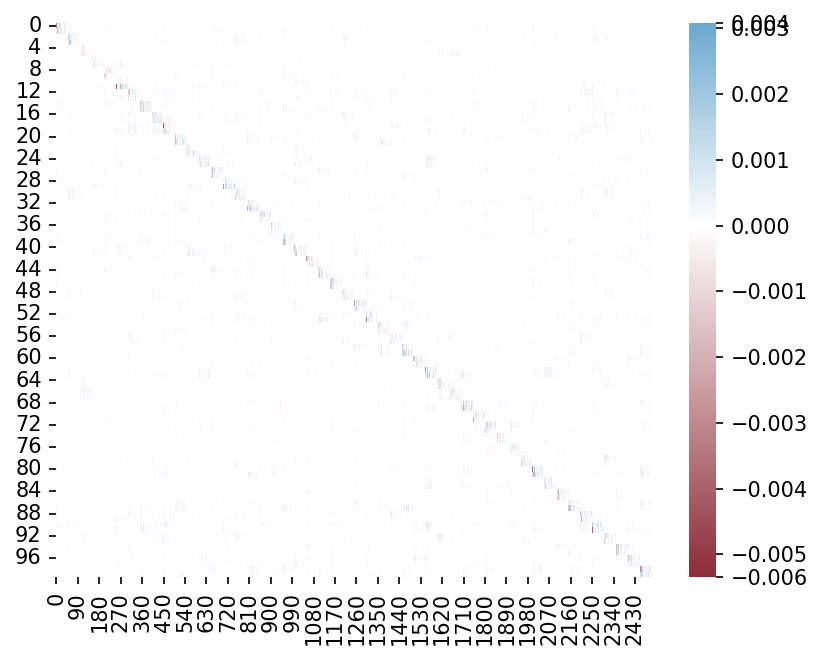

In [85]:
f = plt.figure()
sns.heatmap(J, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J), vmax=np.max(J))))

<AxesSubplot: >

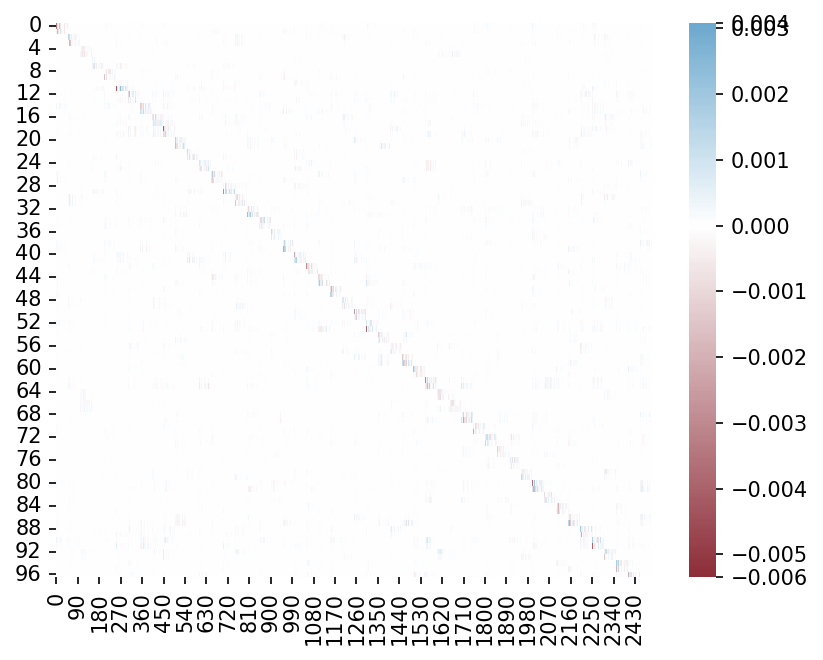

In [86]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg_x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg_x), vmax=np.max(dg_x))), ax=ax1)

<AxesSubplot: >

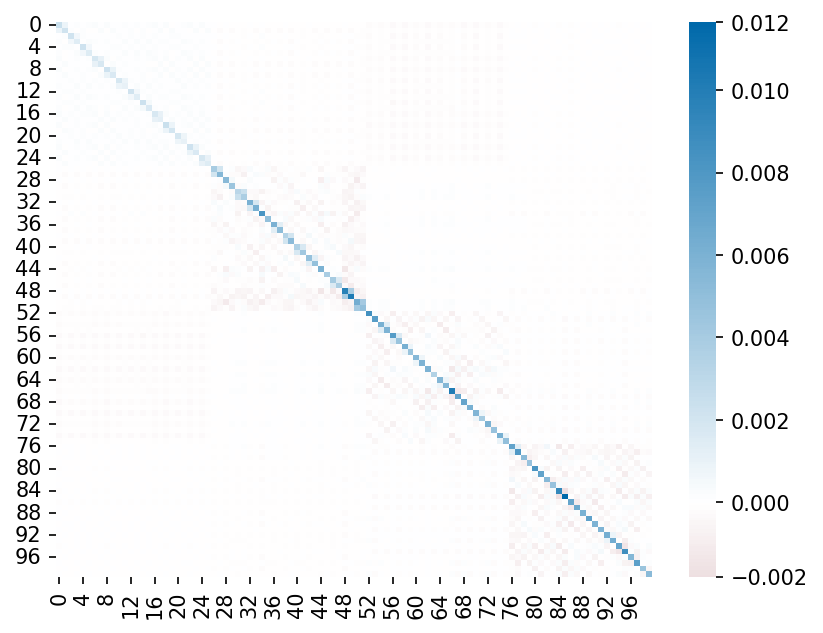

In [150]:
f = plt.figure()
sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))))

In [151]:
inv = np.linalg.inv(dg)
#from scipy.linalg import pinv
#inv = pinv(dg)
print(dg.shape)

(97, 97)


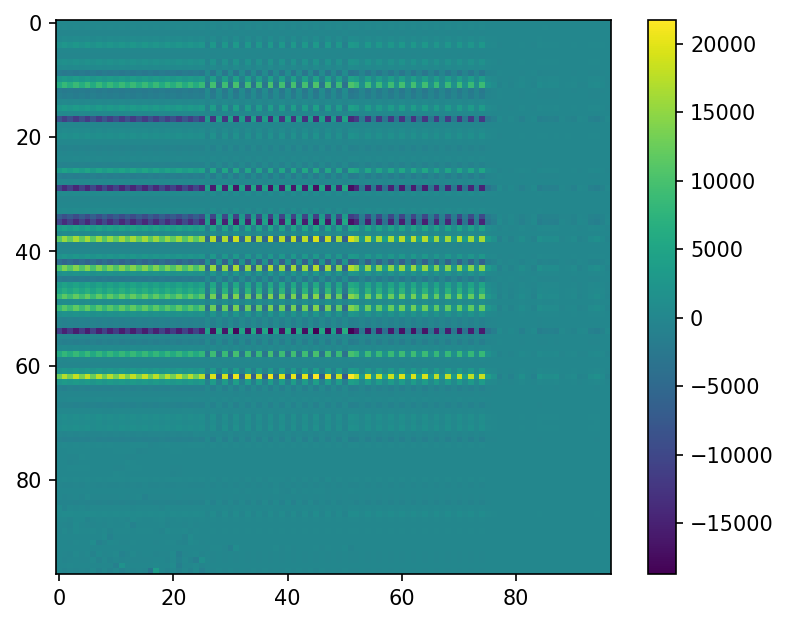

In [152]:
plt.imshow(inv)
plt.colorbar()

In [153]:
H = H +1e-5*np.eye(len(H))

<AxesSubplot: >

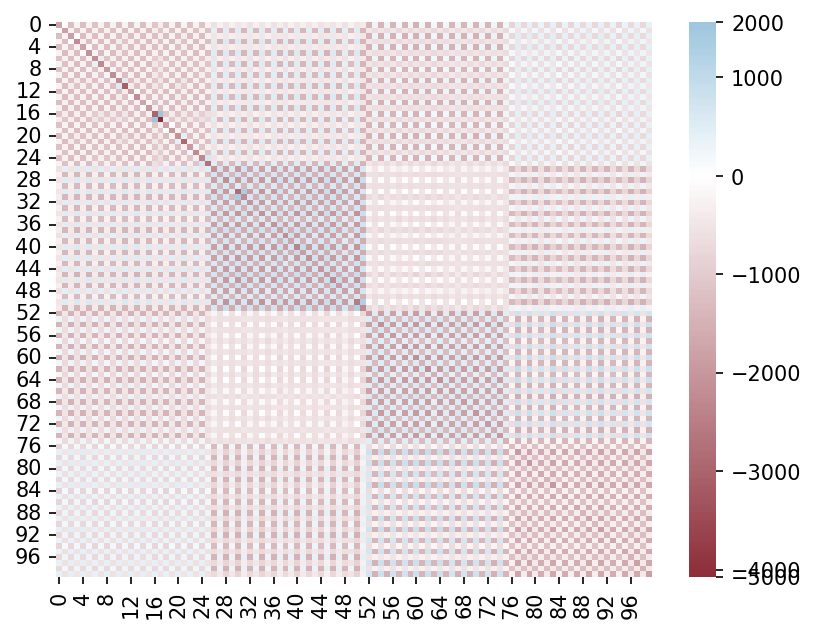

In [154]:
H_inv = compute_inverse_symmetric_matrix(H)
f = plt.figure()
sns.heatmap(-H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(-H_inv), vmax=np.max(-H_inv))))

In [155]:
print(dg.shape, w_sorted_sub.shape)

(97, 97) (100, 97)


<AxesSubplot: >

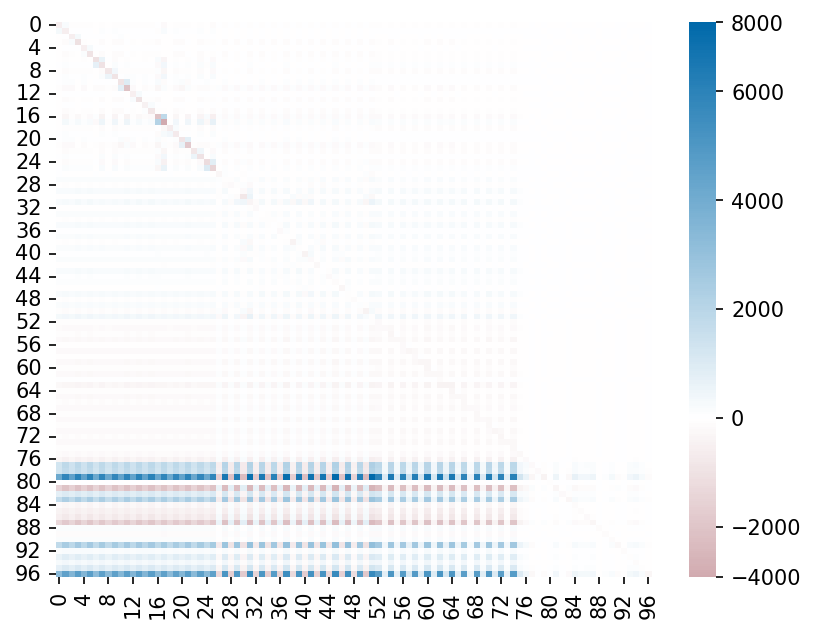

In [156]:
x = w_sorted_sub[0:97] @ (-np.linalg.inv(dg))
f = plt.figure()
sns.heatmap(x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(x), vmax=np.max(x))))

In [157]:
print(x)

[[-6.13987427e+02  1.74850739e+02 -8.79502106e+01 ... -1.16080523e+01
  -4.30453110e+00  1.51654387e+00]
 [ 2.84549255e+02 -5.98586243e+02  5.05498390e+01 ...  5.53352976e+00
   3.19790602e+00  1.75312236e-02]
 [-1.61643906e+01  4.37316666e+01 -5.72087341e+02 ... -3.61460757e+00
   5.53813457e+00 -1.82188116e-02]
 ...
 [ 2.57996735e+02  3.41391632e+02  2.80733978e+02 ... -1.27178566e+02
  -1.57221270e+01 -1.61185207e+01]
 [ 7.04000061e+02  1.00413611e+03  7.58434814e+02 ...  5.92279243e+01
  -7.56790009e+01 -2.75120087e+01]
 [ 3.27204150e+03  4.52247705e+03  3.52549634e+03 ...  4.03625916e+02
   2.06548370e+02 -3.11581146e+02]]


In [158]:
dy_dx

Array([[-1.0310648e-02, -1.7709004e-02, -8.8911112e-03, ...,
        -5.5248250e-04,  6.6873645e-06, -3.3713764e-04],
       [ 1.6438399e-02,  5.1229484e-03,  2.8841509e-03, ...,
         3.7845437e-04,  1.2790735e-04,  1.7202062e-04],
       [-8.7798387e-04,  4.0595964e-04, -6.1773008e-04, ...,
        -2.8386369e-04,  3.1077757e-04, -1.2233062e-04],
       ...,
       [-3.3856527e-04,  2.2412204e-04, -4.5626273e-04, ...,
        -2.3167807e-04, -3.2732575e-04, -7.0427766e-04],
       [ 8.4290333e-04, -6.5993820e-04,  1.1146279e-03, ...,
         3.0912431e-03, -1.1406816e-02,  1.9713312e-03],
       [-4.6608126e-04,  3.1478333e-04, -5.8381358e-04, ...,
         4.9121892e-03,  6.5324930e-03,  9.1032181e-03]], dtype=float32)

In [159]:
dy

Array([[-1.01952795e-02, -1.75882261e-02, -8.82642437e-03, ...,
        -5.48430718e-04,  6.13746624e-06, -3.34761047e-04],
       [ 1.62888691e-02,  5.03046531e-03,  2.83556106e-03, ...,
         3.76047363e-04,  1.28008789e-04,  1.71470077e-04],
       [-8.62163783e-04,  4.10228735e-04, -6.07913302e-04, ...,
        -2.81102024e-04,  3.08636052e-04, -1.20790042e-04],
       ...,
       [-3.33274103e-04,  2.18804140e-04, -4.51751635e-04, ...,
        -2.27607423e-04, -3.25435190e-04, -6.93955284e-04],
       [ 8.36487219e-04, -6.55665935e-04,  1.10711064e-03, ...,
         3.08129075e-03, -1.13810562e-02,  1.96215464e-03],
       [-4.65123041e-04,  3.19882965e-04, -5.80761873e-04, ...,
         4.89935745e-03,  6.51723519e-03,  9.07334313e-03]],      dtype=float32)

In [160]:
-H_inv @ J

Array([[-1.00831203e-02, -1.74699966e-02, -8.76318477e-03, ...,
        -5.44547103e-04,  5.52879646e-06, -3.32952477e-04],
       [ 1.61429346e-02,  4.94112633e-03,  2.78836396e-03, ...,
         3.73479212e-04,  1.27772801e-04,  1.70256011e-04],
       [-8.47158197e-04,  4.14287701e-04, -5.98471670e-04, ...,
        -2.78569758e-04,  3.06324102e-04, -1.19980425e-04],
       ...,
       [-3.29808798e-04,  2.17823530e-04, -4.48053761e-04, ...,
        -2.25736760e-04, -3.26061621e-04, -6.91367313e-04],
       [ 8.30730540e-04, -6.52682676e-04,  1.09986891e-03, ...,
         3.07196868e-03, -1.13547873e-02,  1.95513153e-03],
       [-4.61280550e-04,  3.18522681e-04, -5.76499966e-04, ...,
         4.89016715e-03,  6.50605559e-03,  9.05637350e-03]],      dtype=float32)

In [172]:
lu, piv= jax.scipy.linalg.lu_factor(dg)
hinte = jax.scipy.linalg.lu_solve((lu, piv), -dg_x)

In [175]:
w_sorted_sub @ hinte

Array([[-1.0310642e-02, -1.7709015e-02, -8.8911084e-03, ...,
        -5.5248168e-04,  6.6866701e-06, -3.3714020e-04],
       [ 1.6438400e-02,  5.1229461e-03,  2.8841482e-03, ...,
         3.7845710e-04,  1.2790514e-04,  1.7201962e-04],
       [-8.7797944e-04,  4.0595519e-04, -6.1773049e-04, ...,
        -2.8386444e-04,  3.1077949e-04, -1.2232950e-04],
       ...,
       [-3.3823299e-04,  2.2394460e-04, -4.5625778e-04, ...,
        -2.3161335e-04, -3.2721323e-04, -7.0423307e-04],
       [ 8.4279961e-04, -6.5978727e-04,  1.1146292e-03, ...,
         3.0912210e-03, -1.1406810e-02,  1.9712921e-03],
       [-4.6642488e-04,  3.1481628e-04, -5.8381527e-04, ...,
         4.9120458e-03,  6.5323850e-03,  9.1030868e-03]], dtype=float32)

In [174]:
lu, piv= jax.scipy.linalg.lu_factor(H)
jax.scipy.linalg.lu_solve((lu, piv), -J)

Array([[-1.00831771e-02, -1.74700152e-02, -8.76320805e-03, ...,
        -5.44531678e-04,  5.53585460e-06, -3.32925847e-04],
       [ 1.61429178e-02,  4.94114263e-03,  2.78833346e-03, ...,
         3.73464718e-04,  1.27817126e-04,  1.70248575e-04],
       [-8.47207091e-04,  4.14288108e-04, -5.98492683e-04, ...,
        -2.78560765e-04,  3.06335918e-04, -1.19955490e-04],
       ...,
       [-3.29787465e-04,  2.17826251e-04, -4.48061473e-04, ...,
        -2.25716227e-04, -3.26047710e-04, -6.91342168e-04],
       [ 8.30709818e-04, -6.52690360e-04,  1.09986472e-03, ...,
         3.07201291e-03, -1.13547975e-02,  1.95518718e-03],
       [-4.61254880e-04,  3.18525272e-04, -5.76505088e-04, ...,
         4.89018392e-03,  6.50607888e-03,  9.05639119e-03]],      dtype=float32)

In [8]:
U = Y_flat @ w_sorted
dy2, H2, J2 = d_y_star_d_x_outer(KL_divergence, X, Y_unflattener(U))

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


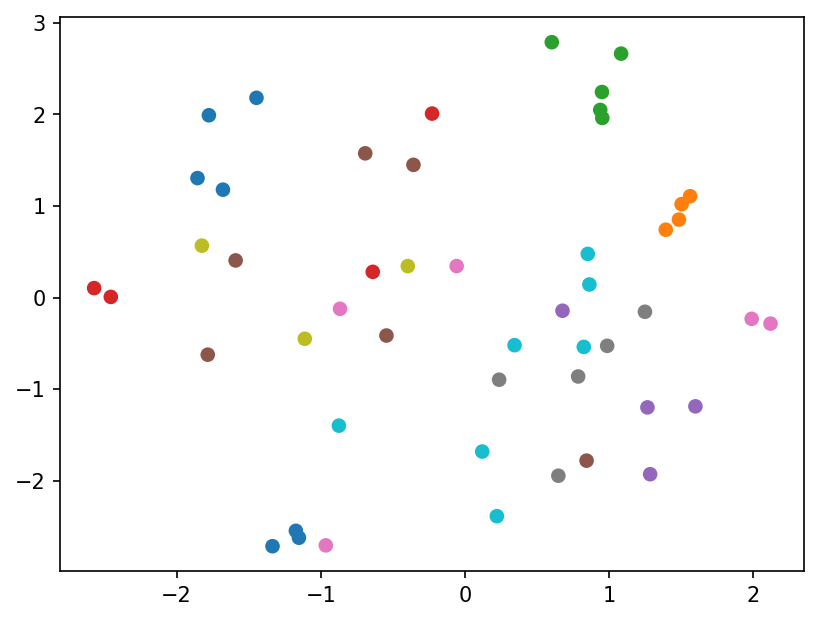

In [9]:
f = plt.figure()
plt.scatter(*Y_star.T, c=y, cmap='tab10')

In [11]:
Y_unflattener(U).T

Array([[ 2.09443551e-02,  5.32265343e-02,  9.90514159e-02,
         6.01038150e-02, -8.18646178e-02, -1.38164312e-01,
        -2.47916505e-01,  2.48546824e-02, -2.37660512e-01,
         7.48367086e-02,  3.47088166e-02,  7.77415782e-02,
         1.95417538e-01,  1.09379716e-01, -4.61339086e-01,
        -6.89975619e-02,  4.98384498e-02,  3.13536167e-01,
        -4.28944230e-02, -8.26675817e-03, -6.58847541e-02,
         8.49189330e-03, -1.51123814e-02, -1.95083499e-01,
        -1.10428229e-01, -1.87688768e-01,  1.26726523e-01,
         3.02240014e-01, -2.24319905e-01, -1.72766507e-01,
         1.54152840e-01,  1.92579359e-01,  3.01808361e-02,
        -1.64338723e-01, -2.93625385e-01, -2.69989014e-01,
         3.60410154e-01,  4.33104813e-01, -6.00864530e-01,
        -4.48124595e-02,  3.87226254e-01,  4.31187898e-02,
         1.17648207e-01, -2.52621204e-01,  1.45383194e-01,
        -2.80053943e-01, -7.31560946e-01, -1.38000727e-01,
         1.04170036e+00,  3.93613300e-05],
       [-7.26

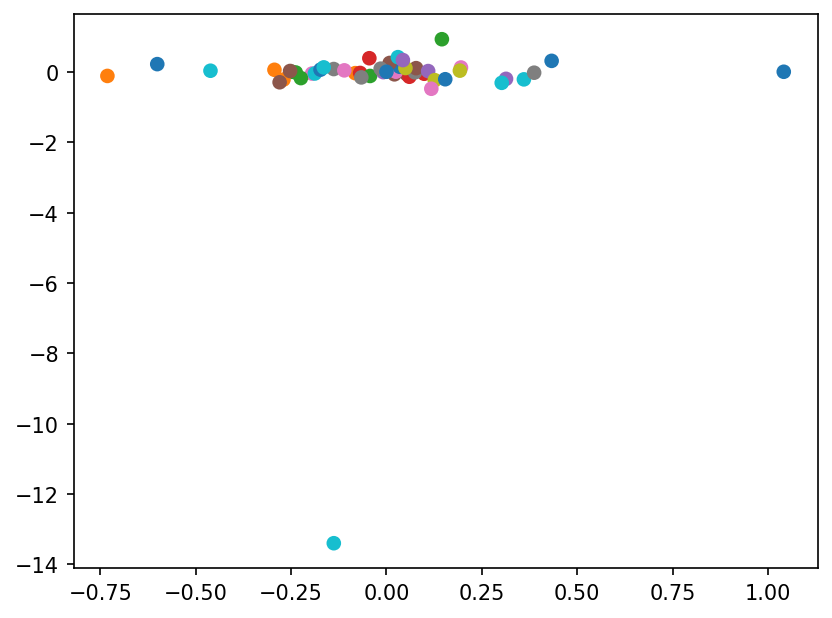

In [10]:
f = plt.figure()
plt.scatter(*Y_unflattener(U).T, c=y, cmap='tab10')

<AxesSubplot: >

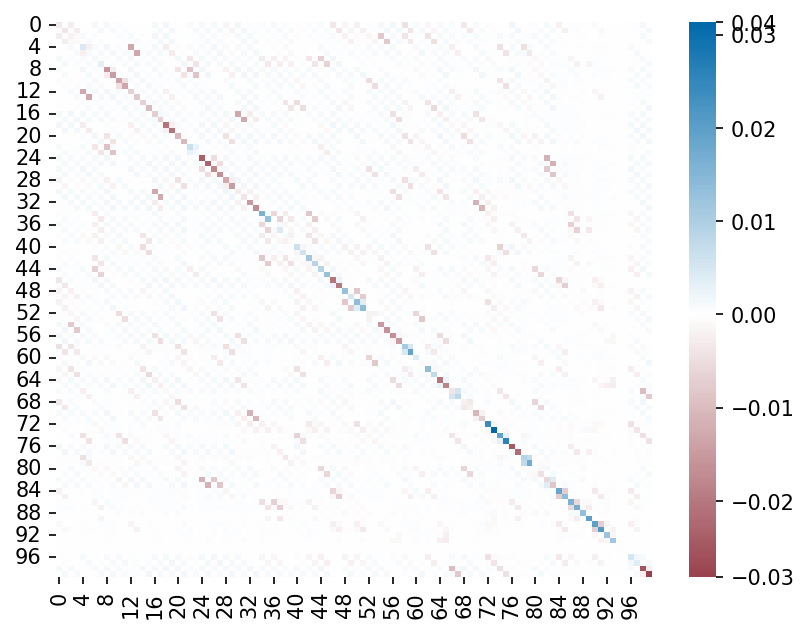

In [43]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H2, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2), vmax=np.max(H2))), ax=ax1)

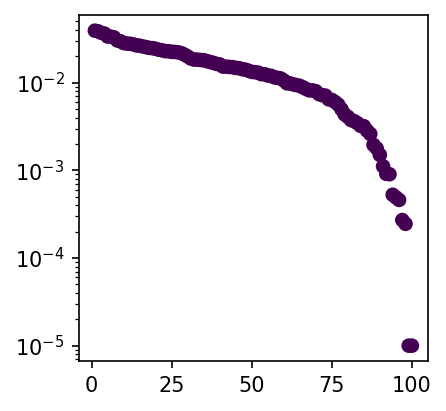

In [44]:
a, s, b = np.linalg.svd(H2)
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

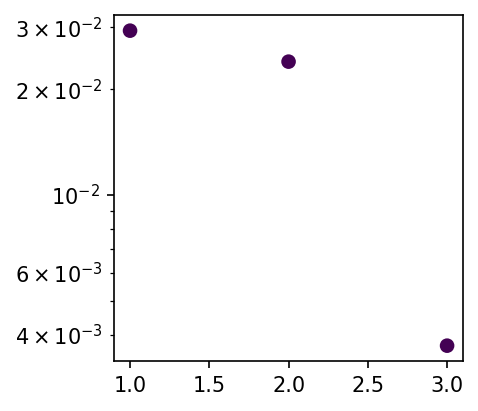

In [45]:
a, s, b = np.linalg.svd(H2[97:, 97:])
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

In [62]:
def g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R^nx2
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, num = y2q(Y)
    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    return np.ravel(4 * np.sum((PQ_exp * Y_diffs_wt), axis=1))@v

In [63]:
w_sorted_sub = w_sorted
g_fun2 = lambda u: g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [64]:
dg = jax.jacrev(g_fun2)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

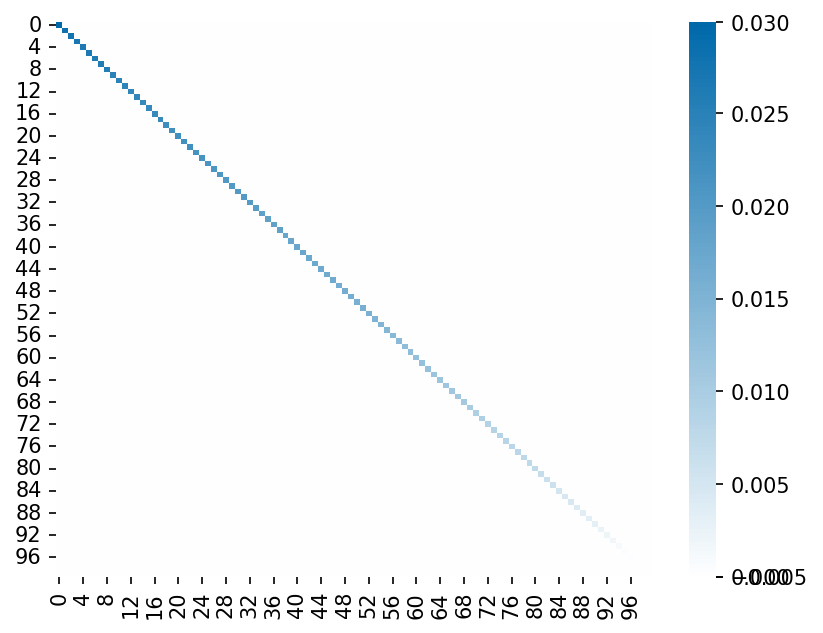

In [65]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg), vmax=np.max(dg))), ax=ax1)

In [70]:
a, s, b = np.linalg.svd(dg[97:,97:])

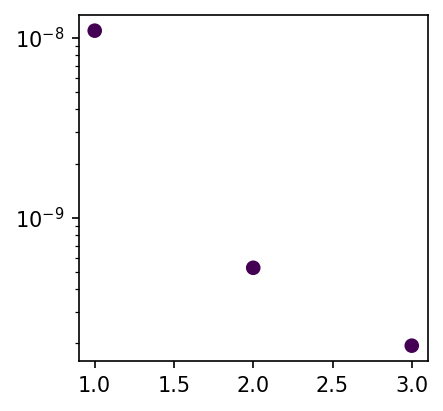

In [71]:
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

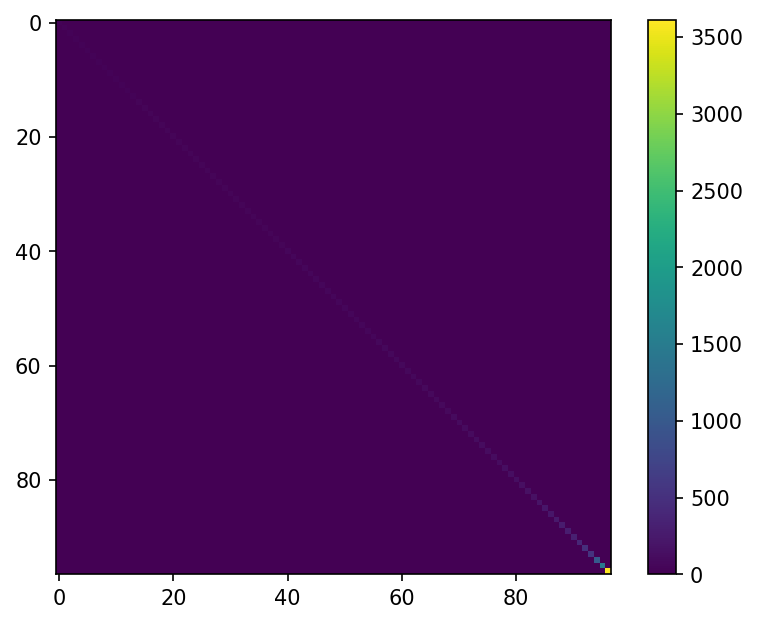

In [72]:
plt.imshow(np.linalg.inv(dg[:97, :97]))
plt.colorbar()

In [73]:
g_fun_x = lambda x: g2(x, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)
dg_x = jax.jacrev(g_fun_x)(X_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

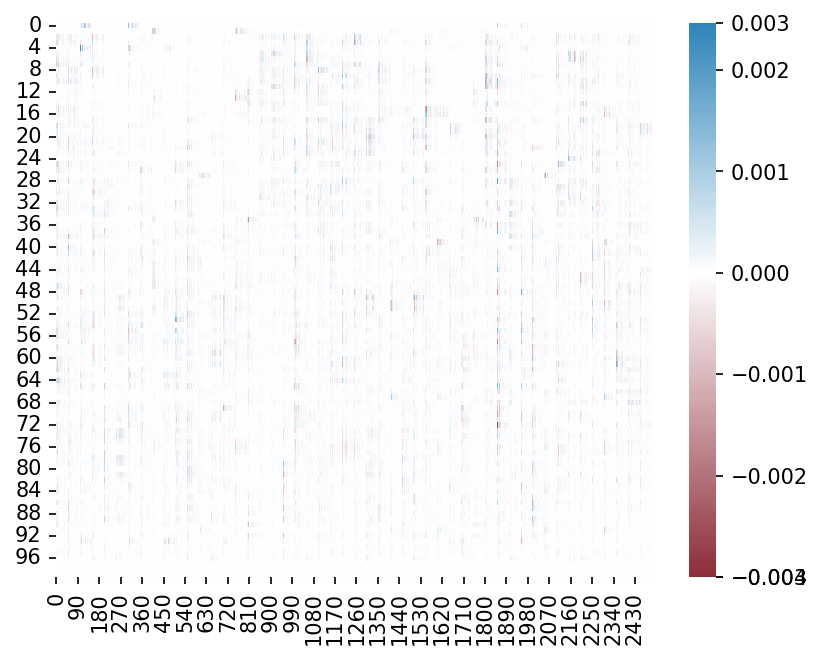

In [77]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg_x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg_x), vmax=np.max(dg_x))), ax=ax1)

In [74]:
du_dx = - np.linalg.inv(dg) @ dg_x

In [75]:
dy_dx = w_sorted_sub @ du_dx

<AxesSubplot: >

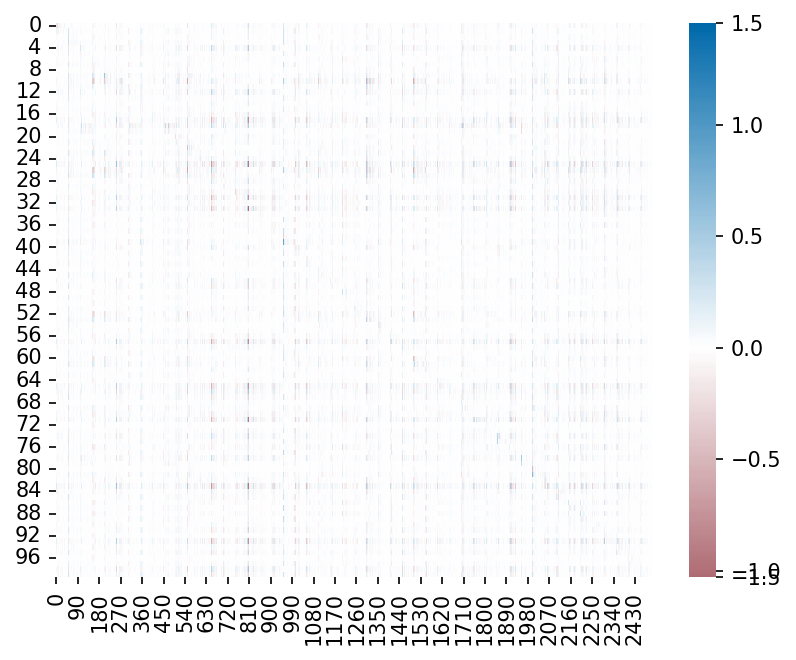

In [76]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_dx), vmax=np.max(dy_dx))), ax=ax1)

In [16]:
f2(Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([ 1.63505320e-07, -2.62778485e-07, -1.04133505e-07,  2.87545845e-07,
       -4.50090738e-07, -3.99537385e-07,  2.24215910e-07, -1.08178938e-07,
        3.10261385e-07,  3.39729013e-07,  1.86264515e-07,  1.02561899e-07,
        5.85423550e-07, -6.95232302e-07,  1.94530003e-07, -1.75787136e-08,
        3.79004632e-08, -2.78232619e-07,  1.14378054e-08, -2.01631337e-07,
        3.83326551e-07, -3.47208697e-08,  8.41973815e-08, -6.33299351e-08,
       -5.27768862e-07, -1.35041773e-07,  1.15018338e-07, -4.57221176e-08,
        1.13854185e-07, -3.33006028e-07, -5.07570803e-08,  2.46684067e-07,
       -2.08354322e-07, -1.47847459e-07,  8.34697857e-07,  4.11644578e-07,
       -5.69561962e-08, -1.97323970e-07,  2.08849087e-07, -7.02275429e-08,
        4.80213203e-08,  1.95577741e-08, -1.52504072e-08,  2.68133590e-07,
       -2.53377948e-07,  2.58689397e-07, -7.17409421e-08, -8.30623321e-08,
       -4.80911694e-07, -2.00700015e-07,  9.88366082e-08,  1.01135811e-06,
       -2.57015927e-07, -

In [17]:
f2(Y_flat + 5)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([ 1.62690412e-07, -2.60217348e-07, -1.06403604e-07,  2.94996426e-07,
       -4.46976628e-07, -3.88128683e-07,  2.20374204e-07, -1.10303517e-07,
        2.91271135e-07,  3.33006028e-07,  1.64727680e-07,  8.53324309e-08,
        5.85358066e-07, -6.90750312e-07,  2.15950422e-07, -8.03265721e-09,
        4.64351615e-08, -2.74914782e-07,  3.30328476e-08, -1.77184120e-07,
        3.77069227e-07, -3.96976247e-08,  7.36763468e-08, -7.98609108e-08,
       -5.27536031e-07, -1.34110451e-07,  1.00233592e-07, -3.13739292e-08,
        1.14436261e-07, -3.34985089e-07, -5.71599230e-08,  2.55298801e-07,
       -2.28115823e-07, -1.54133886e-07,  8.35279934e-07,  4.09316272e-07,
       -4.43542376e-08, -1.98837370e-07,  1.99768692e-07, -7.50296749e-08,
        6.48433343e-08,  2.09547579e-08, -1.16415322e-08,  2.78145308e-07,
       -2.46393029e-07,  2.54236511e-07, -6.53672032e-08, -7.59318937e-08,
       -4.82657924e-07, -2.15484761e-07,  9.48784873e-08,  9.99774784e-07,
       -2.65761628e-07, -